In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random, gc, keras, os

from keras import backend as K
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

%matplotlib inline

Using TensorFlow backend.


# Load Dataset

In [2]:
train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/validation.csv')
test_df = pd.read_csv('./data/test.csv')

print('Train:\t\t', train_df.shape, '\t', len(train_df['label'].unique()))
print('Validation:\t', val_df.shape, '\t', len(val_df['label'].unique()))
print('Test:\t\t', test_df.shape)

Train:		 (194828, 3) 	 128
Validation:	 (6400, 3) 	 128
Test:		 (12800, 2)


In [3]:
train_df.head()

,id,label,url
0,1,5,https://img13.360buyimg.com/imgzone/jfs/t2857/...
1,2,5,http://www.tengdakeli.cn/350/timg01/uploaded/i...
2,3,5,https://img13.360buyimg.com/imgzone/jfs/t8899/...
3,4,5,http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...
4,5,5,http://a.vpimg4.com/upload/merchandise/287883/...


In [4]:
# Helper function
train_dir = './data/train'
val_dir = './data/validation'
test_dir = './data/test'

# Define resized image size
img_size = (150, 150, 3)

# ResNet from Scratch

In [5]:
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 130:
        lr *= 1e-2
    elif epoch > 100:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs, filters=16, kernel_size=3, strides=1, activation='relu', 
                 batch_normalization=True, l2_ratio=1e-4):
    """ Resnet single layer """
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', 
                  activation=None, kernel_initializer='he_normal', kernel_regularizer=l2(l2_ratio))
    y = conv(inputs)
    if batch_normalization is True:
        y = BatchNormalization()(y)
    if activation is not None:
        y = Activation(activation)(y)
        
    return y


def residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=1e-4):
    """ 
    ResNet layers with multiple Conv2D + Batch_Normalization + Activation structure 
    """
    # Conv block 1
    strides = 1
    if downsample is True:
        strides = 2
        
    y = resnet_layer(x, filters=filters, kernel_size=kernel_size, strides=strides, 
                     activation='relu', batch_normalization=True, l2_ratio=l2_ratio)
    
    y = resnet_layer(y, filters=filters, kernel_size=kernel_size, strides=1, 
                     activation=None, batch_normalization=True, l2_ratio=l2_ratio)
    
    if downsample is True:
        x = resnet_layer(x, filters=filters, kernel_size=1, strides=strides, 
                         activation=None, batch_normalization=False, l2_ratio=l2_ratio)
        
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
        
    return x


def resnet_model(input_shape, num_classes=10, l2_ratio=1e-4):
    """ Build ResNet structure """
    # define inputs
    inputs = Input(shape=input_shape, name='inputs')
    
    # block 1: CNN + BN + ReLU
    x = resnet_layer(inputs=inputs, filters=16, kernel_size=3, strides=1, l2_ratio=l2_ratio)
    
    # block 2: stack of residual blocks
    x = residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    
    # block 3: stack of residual blocks
    x = residual(x, filters=32, kernel_size=3, downsample=True, l2_ratio=l2_ratio)
    x = residual(x, filters=32, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=32, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    
    # block 4: stack of residual blocks
    x = residual(x, filters=64, kernel_size=3, downsample=True, l2_ratio=l2_ratio)
    x = residual(x, filters=64, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=64, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    
    # block 5: final output
    x = MaxPooling2D(pool_size=8, strides=None, padding='valid')(x)
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.25, name='dropout')(x)
    outputs = Dense(units=num_classes, activation='softmax', kernel_initializer='he_normal')(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [6]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
# training set

# train_gen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest')

train_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    train_dir, 
    batch_size=128, 
    classes=classes, 
    target_size=img_size[:2])

# validation set
val_gen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_gen.flow_from_directory(
    val_dir, 
    batch_size=286, 
    classes=classes, 
    target_size=img_size[:2])

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [7]:
# Define resnet model
resnet = resnet_model(input_shape=img_size, num_classes=128, l2_ratio=1e-4)

resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 16) 448         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 150, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 150, 150, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
resnet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/resnet-naive-initial.h5', 
                             verbose=0, monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = resnet.fit_generator(train_generator, steps_per_epoch=100, epochs=100, verbose=2, 
                              callbacks=callbacks, validation_data=val_generator, validation_steps=22)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/100
Learning rate:  0.001
 - 190s - loss: 8.1911 - acc: 0.0176 - val_loss: 5.6728 - val_acc: 0.0191
Epoch 2/100
Learning rate:  0.001
 - 173s - loss: 4.9582 - acc: 0.0373 - val_loss: 4.8142 - val_acc: 0.0482
Epoch 3/100
Learning rate:  0.001
 - 170s - loss: 4.6083 - acc: 0.0665 - val_loss: 4.6163 - val_acc: 0.0593
Epoch 4/100
Learning rate:  0.001
 - 173s - loss: 4.3194 - acc: 0.0970 - val_loss: 4.3159 - val_acc: 0.1135
Epoch 5/100
Learning rate:  0.001
 - 170s - loss: 4.1577 - acc: 0.1207 - val_loss: 4.2422 - val_acc: 0.1209
Epoch 6/100
Learning rate:  0.001
 - 179s - loss: 3.9351 - acc: 0.1583 - val_loss: 4.2442 - val_acc: 0.1241
Epoch 7/100
Learning rate:  0.001
 - 171s - loss: 3.7617 - acc: 0.1886 - val_loss: 3.9215 - val_acc: 0.1659
Epoch 8/100
Learning rate:  0.001
 - 170s - loss: 3.5516 - acc: 0.2197 - val_loss: 3.7188 - val_acc: 0.2066
Epoch 9/100
Learning rate:  0.001
 - 170s - loss: 3.3904 - acc: 0.2455 - val_loss: 4.2041 - val_acc: 0.1232
Epoch 

 - 160s - loss: 1.6298 - acc: 0.6059 - val_loss: 2.2100 - val_acc: 0.4884
Epoch 77/100
Learning rate:  0.001
 - 164s - loss: 1.6505 - acc: 0.6020 - val_loss: 2.0511 - val_acc: 0.5213
Epoch 78/100
Learning rate:  0.001
 - 160s - loss: 1.6703 - acc: 0.5960 - val_loss: 1.9045 - val_acc: 0.5455
Epoch 79/100
Learning rate:  0.001
 - 163s - loss: 1.6972 - acc: 0.5885 - val_loss: 1.8874 - val_acc: 0.5524
Epoch 80/100
Learning rate:  0.001
 - 161s - loss: 1.6581 - acc: 0.5953 - val_loss: 1.9715 - val_acc: 0.5339
Epoch 81/100
Learning rate:  0.001
 - 163s - loss: 1.6992 - acc: 0.5899 - val_loss: 2.0978 - val_acc: 0.5149
Epoch 82/100
Learning rate:  0.001
 - 162s - loss: 1.6726 - acc: 0.5955 - val_loss: 1.9966 - val_acc: 0.5318
Epoch 83/100
Learning rate:  0.001
 - 163s - loss: 1.6846 - acc: 0.5970 - val_loss: 1.9248 - val_acc: 0.5466
Epoch 84/100
Learning rate:  0.001
 - 165s - loss: 1.7129 - acc: 0.5866 - val_loss: 2.0407 - val_acc: 0.5226
Epoch 85/100
Learning rate:  0.001
 - 160s - loss: 1.6

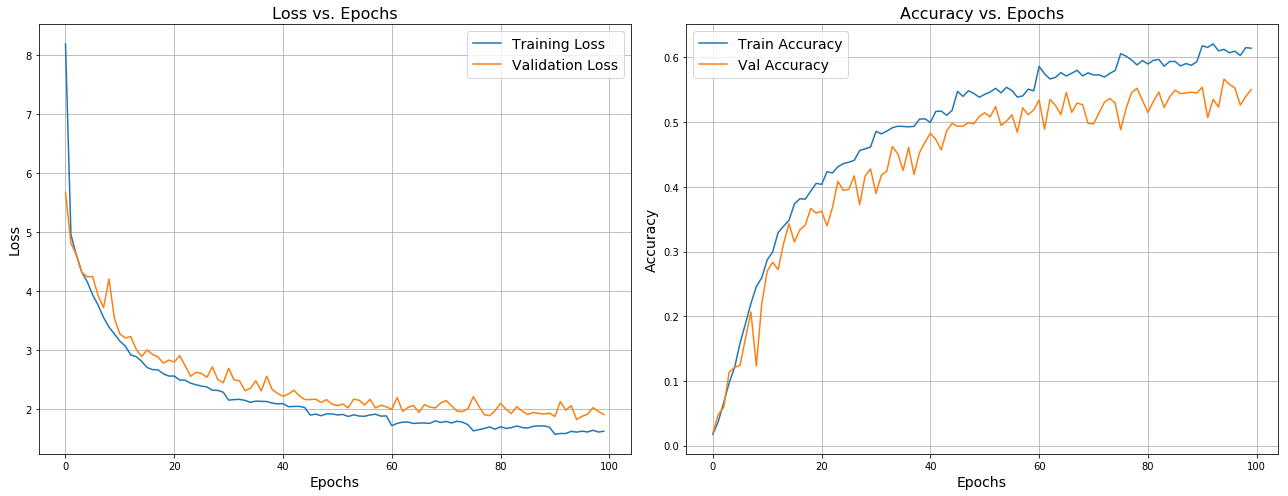

In [9]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

### Make Predictions

In [ ]:
# Load test images
test_ids = []
test_images = []
for idx in test_df['id'].values:
    if os.path.exists('./data/test/' + str(idx) + '.jpg'):
        img = Image.open('./data/test/' + str(idx) + '.jpg')
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(img_size[:2])
        img = np.asarray(img, dtype=K.floatx())
        test_images.append(img)
        test_ids.append(idx)

# Re-scale the images
test_images = np.array(test_images, dtype=K.floatx())
test_images = test_images / 255.0

In [ ]:
# Load the saved model
resnet = load_model('./models/resnet-naive-initial.h5')

# Make predictions
test_pred = resnet.predict(test_images)
test_label = np.argmax(test_pred, axis=1) + 1

In [ ]:
# Sample submission
sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# Merge together
df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# Fill missing values
n = df_submission['predicted'].isnull().sum()
guess = np.random.choice(range(1, 129), n, replace=True)
df_submission.loc[df_submission['predicted'].isnull(), 'predicted'] = guess
df_submission['predicted'] = df_submission['predicted'].astype(int)

# Save to disk
df_submission.to_csv('./result/resnet-naive-initial.csv', 
                     columns=['id', 'predicted'], index=False)

_ = gc.collect()